In [2]:

!pip uninstall -y protobuf grpcio


!pip install -q "flwr[simulation]" flwr-datasets[vision] torch torchvision matplotlib
!pip install -U "protobuf==4.25.3" "grpcio==1.60.0"



Found existing installation: protobuf 5.29.5
Uninstalling protobuf-5.29.5:
  Successfully uninstalled protobuf-5.29.5
Found existing installation: grpcio 1.76.0
Uninstalling grpcio-1.76.0:
  Successfully uninstalled grpcio-1.76.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.1/727.1 k

In [10]:
import os
import subprocess
import sys

def install_packages():
    print("Installing dependencies... this may take a minute.")
    subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "protobuf", "grpcio"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "flwr[simulation]", "flwr-datasets[vision]", "torch", "torchvision", "matplotlib"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "protobuf==5.28.0", "grpcio==1.70.0"])
    print("Installation complete.")

try:
    import flwr
except ImportError:
    install_packages()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor

import flwr as fl
from flwr.client import NumPyClient
from flwr.simulation import start_simulation
from flwr.server.strategy import FedAvg
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

DEVICE = torch.device("cpu")
print(f"Training on {DEVICE} for stability.")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

def train(net, trainloader, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    net.train()
    for _ in range(epochs):
        for batch in trainloader:
            images = batch["img"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()

def test(net, testloader):
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images = batch["img"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy

def load_data(partition_id):
    fds = FederatedDataset(
        dataset="uoft-cs/cifar10",
        partitioners={"train": IidPartitioner(num_partitions=10)},
    )
    partition = fds.load_partition(partition_id)
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)

    pytorch_transforms = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train_test["train"], batch_size=32, shuffle=True)
    testloader = DataLoader(partition_train_test["test"], batch_size=32)
    return trainloader, testloader

class FlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = {k: torch.tensor(v) for k, v in params_dict}
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train(self.net, self.trainloader, epochs=1)
        return self.get_parameters(config={}), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader.dataset), {"accuracy": float(accuracy)}

def client_fn(cid: str):
    net = Net().to(DEVICE)
    trainloader, valloader = load_data(partition_id=int(cid))
    return FlowerClient(cid, net, trainloader, valloader).to_client()

def evaluate_metrics_aggregation_fn(results):

    accuracies = [num_examples * m["accuracy"] for num_examples, m in results]
    examples = [num_examples for num_examples, _ in results]
    return {"accuracy": sum(accuracies) / sum(examples)}

print("Starting simulation...")
client_resources = {"num_cpus": 1, "num_gpus": 0.0}

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=10,
    min_evaluate_clients=10,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
)

hist = start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=3),
    client_resources=client_resources,
    strategy=strategy,
)

print(f"\nFinal Accuracy: {hist.metrics_distributed['accuracy'][-1][1]}")

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout


Training on cpu for stability.
Starting simulation...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-12-18 17:32:11,007	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 9192977204.0, 'object_store_memory': 3939847372.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=8532) 2025-12-18 17:32:24.887038: E external


Final Accuracy: 0.1914


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


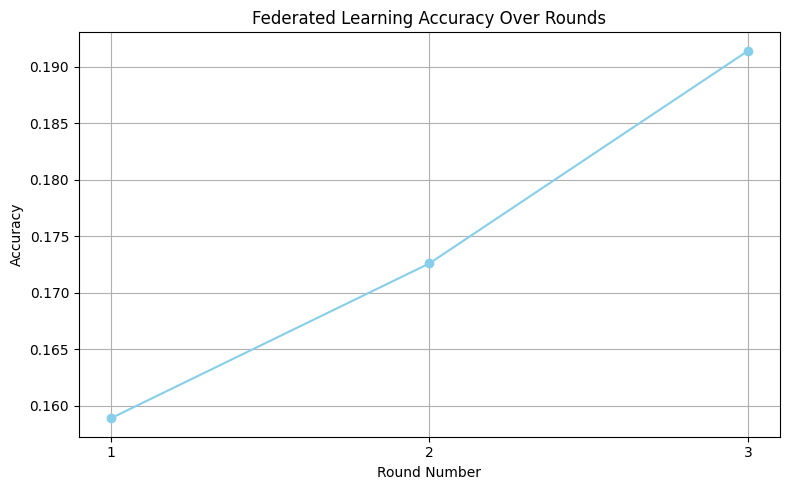

In [11]:
import matplotlib.pyplot as plt

rounds = [item[0] for item in hist.metrics_distributed['accuracy']]
accuracies = [item[1] for item in hist.metrics_distributed['accuracy']]

plt.figure(figsize=(8, 5))
plt.plot(rounds, accuracies, marker='o', linestyle='-', color='skyblue')
plt.title('Federated Learning Accuracy Over Rounds')
plt.xlabel('Round Number')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(rounds)
plt.tight_layout()
plt.show()